In [1]:
import torchvision
from research_task_utils import *
import importlib
from torchsummary import summary
# importlib.reload(research_task_utils)

In [2]:
batchsize = 512
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)
traindata = torchvision.datasets.CIFAR100(root="./dataset", train=True, download=True, transform=transform)
testdata = torchvision.datasets.CIFAR100(root="./dataset", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
32*32*3

3072

In [4]:
class SimpleModel(torch.nn.Module):
    def __init__(self, model_hyperparams):
        super().__init__()
        
        self.hyperparams = model_hyperparams
        
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3072, model_hyperparams),
            torch.nn.ReLU(),
            torch.nn.Linear(model_hyperparams, 100),
            torch.nn.Softmax(dim=-1)
        )
    
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)

    def forward(self, x):
        return self.layers(x)

In [6]:
model = SimpleModel(100).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.CrossEntropyLoss()
statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)

In [76]:
train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=5,
      augmenter=None, checkpoints_dir=None)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


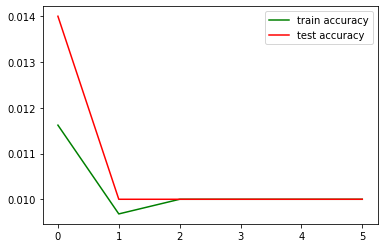

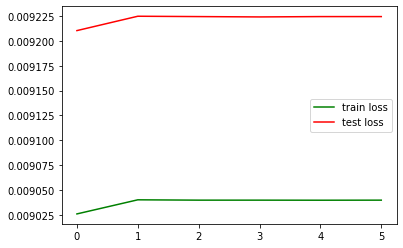

In [70]:
plot_statistics(statistics_list)

In [7]:
print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 100]         307,300
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
           Softmax-5                  [-1, 100]               0
Total params: 317,400
Trainable params: 317,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 1.21
Estimated Total Size (MB): 1.25
----------------------------------------------------------------
None


In [8]:
model.num_of_params()

317400

In [63]:
import statistics

def perform_experiment(device, trainloader, testloader, Model_class, model_hyperparams, epochs_n, repeats_n):
    train_accs = []
    test_accs = []
    
    for k in range(repeats_n):
        model = Model_class(model_hyperparams).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)
        train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=epochs_n)
        train_accs.append(statistics_list["trainacc"][-1])
        test_accs.append(statistics_list["testacc"][-1])
        
    if repeats_n != 1:
        test_accs_std = statistics.stdev(test_accs)
        train_accs_std = statistics.stdev(train_accs)
    else:
        test_accs_std, train_accs_std = 0, 0
        
    result = {"train_acc_mean": statistics.mean(train_accs),
              "train_acc_std": train_accs_std,
              "test_acc_mean": statistics.mean(test_accs),
              "test_acc_std": test_accs_std,
              "num_of_params": model.num_of_params()
             }
    return result


def perform_experiments(device, trainloader, testloader, Model_class, hyperparams_list, epochs_n, repeats_n):
    results = dict()
    for hyperparam in hyperparams_list:
        results[hyperparam] = perform_experiment(device, trainloader, testloader,
                                                   Model_class, hyperparam, epochs_n, repeats_n)
    return results

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.33s/it]


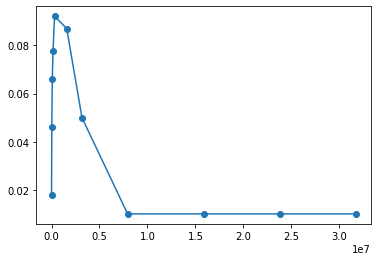

In [67]:
hyperparams_list = [1, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 10000]
results = perform_experiments(device, trainloader, testloader,
                              SimpleModel, hyperparams_list, epochs_n=10, repeats_n=1)

test_accs = []
nums_of_params = []
for hyperparam in hyperparams_list:
    test_accs.append(results[hyperparam]["test_acc_mean"])
    nums_of_params.append(results[hyperparam]["num_of_params"])
    
plt.plot(nums_of_params, test_accs, marker='o')
plt.show()